# Introduction to Neural Networks using PyTorch
See also the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html#sphx-glr-beginner-nlp-deep-learning-tutorial-py)

We want to model

$$f(\mathbf{x}) = \mathbf{A}x + \mathbf{b}$$

where the vector $\mathbf{x}$ is the input and the matrix and vector $\mathbf{A}$ and $\mathbf{b}$ are the parameters $\Theta$ that we want to learn 

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
import string
import nltk
import matplotlib.pyplot as plt

## Case study
We aim at training a network for guessing the correct word having as input an arbitrary string of characters (useful for spelling correction for example).

### Input and output
The output is a set of words (or *phrase words* such as 'you are'), represented as a one-hot vector $\mathbf{w}$ of size $V$, having $V$ the size of the vocabulary.
The input is a set of strings. Each string is represented as a matrix of characters $\mathbf{C} \in \mathbb{R}^{28 \times 28}$, where the 28 dimensions correspond to one ascii lowercase character plus a dimension for whitespace and another dimension for any other character.

Each entry $[c_{ij}]$ represents a bigram which states that the character $j$ is the character that follows $i$ in the string. Given an input string $s$, we calcuate:

$$[c_{ij}] = \frac{count(c_i, c_j)}{\max\limits_{c_x, c_y \in s} count(c_x, c_y)}$$

In [3]:
chars = string.ascii_lowercase + string.whitespace + '#'
CHAR_INDEX = dict((c, i) for i, c in enumerate(chars))

In [4]:
def preprocess(s):
    out = ""
    for c in s.lower():
        if c in CHAR_INDEX.keys():
            out += c
        else:
            out += '#'
    return "".join(out)

In [6]:
preprocess('stri,ng')

'stri#ng'

In [7]:
def string_to_matrix(s, n=2):
    z = preprocess(s)
    C = np.zeros((len(CHAR_INDEX), len(CHAR_INDEX)))
    for a, b in nltk.ngrams(z, n=n):
        C[CHAR_INDEX[a], CHAR_INDEX[b]] += 1
    C /= C.max()
    return C

In [9]:
string_to_matrix(s='abstring')

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
def visualize_string(s, ax, n=2):
    S = string_to_matrix(s, n=n)
    ax.imshow(S, cmap='Greys')
    ax.set_title(s)

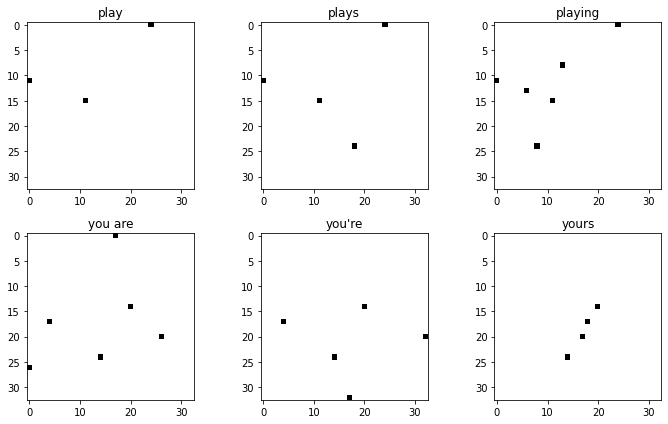

In [11]:
example = [['play', 'plays', 'playing'], ['you are', "you're", 'yours']]
fig, ax = plt.subplots(figsize=(10, 6), ncols=len(example[0]), nrows=len(example))
for i, words in enumerate(example):
    for j, w in enumerate(words):
        visualize_string(w, ax[i,j], n=2)
plt.tight_layout()
plt.show()

## Get predictions
For a given string, the input is a vector $\mathbf{x} \in \mathbb{R}^{28 \times 28 = 784}$ dimensions obtained by concatenating the rows of the string characters matrix. The output will be another vector $\mathbf{\hat{y}} \in \mathbb{R}^V$. But, since we want the output to be a probability distribution, we apply a non-linear transformation to $f(\mathbf{x})$ called *Softmax*:

$$
softmax(\mathbf{\hat{y}}) = \frac{\exp(\mathbf{\hat{y}}_i)}{\sum\limits_{j=1}^{V} \exp(\mathbf{\hat{y}}_j)}
$$

so that the complete non-linear transformation is

$$
\mathbf{\hat{y}} = softmax(\mathbf{A}x + \mathbf{b})
$$

## Training
Given a **loss function** $L(\Theta)$ and a learning parameter $\eta$, training in this example is performed by gradient update as

$$
\Theta^t = \Theta^{t-1} - \eta \nabla_{\Theta} L(\Theta)
$$

## Example

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)

### Get some data

In [13]:
import pycountry
import gettext

In [14]:
countries = ['ITA', 'FRA', 'USA', 'DEU', 'GBR', 'ESP', 'IND', 'CHN']
languages = ['de', 'it', 'fr']
translator = {}
for lang in languages:
    translator[lang] = gettext.translation(
        'iso3166', pycountry.LOCALES_DIR, languages=[lang])
    translator[lang].install()

In [15]:
def get_country_names(country, translator):
    names = []
    c = pycountry.countries.get(alpha_3=country)
    names.append(c.name)
    names.append(c.official_name)
    for _, t in translator.items():
        names.append(t.gettext(c.name))
        names.append(t.gettext(c.official_name))
    return names

In [16]:
get_country_names('ITA', translator)

['Italy',
 'Italian Republic',
 'Italien',
 'Italienische Republik',
 'Italia',
 'Repubblica italiana',
 'Italie',
 'République italienne']

In [17]:
np.random.seed = 42
training_data, testing_data = [], []
for country in countries:
    names = get_country_names(country, translator)
    np.random.shuffle(names)
    training_data.append((names[:6], country))
    testing_data.append((names[6:], country))

## Define the network

In [19]:
N_LABELS = len(countries)
V = len(CHAR_INDEX) * len(CHAR_INDEX)
LABEL_INDEX = dict((l, i) for i, l in enumerate(countries))

In [20]:
class Simple2Gram(nn.Module):
    
    def __init__(self, num_labels, size):
        super(Simple2Gram, self).__init__()
        self.linear = nn.Linear(size, num_labels)
    
    def forward(self, vec):
        return F.log_softmax(self.linear(vec), dim=1)

In [21]:
def vector(s, n=2):
    vec = torch.tensor(string_to_matrix(s, n=n)).float()
    return vec.view(1, -1)

def target(label):
    return torch.LongTensor([LABEL_INDEX[label]])

In [22]:
model = Simple2Gram(N_LABELS, V)

### Model parameters

In [24]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.0232,  0.0252, -0.0071,  ...,  0.0276,  0.0177, -0.0157],
        [-0.0300,  0.0115,  0.0170,  ..., -0.0122,  0.0145,  0.0083],
        [-0.0116,  0.0185, -0.0097,  ..., -0.0171, -0.0184,  0.0082],
        ...,
        [ 0.0020, -0.0153, -0.0293,  ..., -0.0090, -0.0055, -0.0013],
        [ 0.0020,  0.0133,  0.0229,  ..., -0.0209, -0.0280, -0.0164],
        [ 0.0227,  0.0297, -0.0125,  ..., -0.0215,  0.0244, -0.0138]],
       requires_grad=True)
Parameter containing:
tensor([-0.0033,  0.0102, -0.0202, -0.0028, -0.0102, -0.0072, -0.0110,  0.0194],
       requires_grad=True)


### Use the model without training

In [25]:
with torch.no_grad():
    sample = training_data[0]
    vec = vector(sample[0][0], n=2)
    log_probs = model(vec)

In [26]:
log_probs

tensor([[-2.0824, -2.0899, -2.1457, -2.0287, -2.1043, -2.0519, -2.1057, -2.0325]])

## Training

In [27]:
loss = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [28]:
for epoch in range(50):
    for samples, label in training_data:
        for instance in samples:
            model.zero_grad()
            vec = vector(instance)
            tar = target(label)
            log_probs = model(vec)
            L = loss(log_probs, tar)
            L.backward()
            optimizer.step()

In [29]:
with torch.no_grad():
    for test, label in testing_data:
        for word in test:
            vec = vector(word, n=2)
            log_probs = model(vec)
            print(log_probs)
            print('Input string:', word)
            prediction = np.argmax(log_probs.numpy())
            print('Guess:', countries[prediction], '\n')

tensor([[-2.2135e-03, -9.0983e+00, -6.7718e+00, -8.3874e+00, -9.4597e+00,
         -7.7429e+00, -8.7670e+00, -9.7495e+00]])
Input string: Italien
Guess: ITA 

tensor([[-2.9376e-03, -8.7282e+00, -6.5975e+00, -7.4921e+00, -8.5111e+00,
         -8.7735e+00, -7.8870e+00, -9.0400e+00]])
Input string: Italia
Guess: ITA 

tensor([[-7.0280, -0.0110, -6.6074, -5.7738, -6.5041, -5.8140, -7.4789, -7.4250]])
Input string: France
Guess: FRA 

tensor([[-6.7402e+00, -4.5075e-03, -1.1171e+01, -5.9357e+00, -9.8736e+00,
         -1.0059e+01, -8.9994e+00, -7.7296e+00]])
Input string: Repubblica francese
Guess: FRA 

tensor([[-5.8839, -7.7568, -0.0198, -6.0899, -4.6234, -5.8099, -7.5865, -7.1342]])
Input string: United States of America
Guess: USA 

tensor([[-7.6059e+00, -8.5029e+00, -6.3018e-03, -6.9603e+00, -5.5509e+00,
         -8.1030e+00, -8.2595e+00, -8.5828e+00]])
Input string: États-Unis d'Amérique
Guess: USA 

tensor([[-5.0028, -4.2197, -3.9888, -0.0865, -4.4554, -3.8298, -5.5037, -5.2014]])
Inpu

## Evaluate

In [30]:
from torch.distributions import Categorical

In [31]:
entropy = lambda x: Categorical(probs=x).entropy()

In [32]:
predictions, y_true = [], []
with torch.no_grad():
    for test, label in testing_data:
        for word in test:
            vec = vector(word, n=2)
            predictions.append(model(vec))
            y_true.append(LABEL_INDEX[label])
y_true = np.array(y_true)

In [33]:
E = sum([entropy(p) for p in predictions])

In [34]:
E

tensor([31.0945])

In [35]:
y_pred = [np.argmax(p.numpy()) for p in predictions]

In [36]:
from sklearn.metrics import classification_report

In [37]:
print(classification_report(y_true, y_pred, target_names=countries))

              precision    recall  f1-score   support

         ITA       1.00      1.00      1.00         2
         FRA       1.00      1.00      1.00         2
         USA       1.00      1.00      1.00         2
         DEU       1.00      1.00      1.00         2
         GBR       1.00      1.00      1.00         2
         ESP       1.00      1.00      1.00         2
         IND       1.00      1.00      1.00         2
         CHN       1.00      1.00      1.00         2

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



## Make things harder
In the following we simulate some spelling errors to see if the network can handle them

In [38]:
def substitute_chars(s, substitutions=2):
    w = list(s)
    for iteration in range(substitutions):
        n = np.random.choice(list(string.ascii_lowercase))
        i = np.random.randint(0, len(w))
        w[i] = n
    return "".join(w)

def add_chars(s, additions=2):
    w = list(s)
    for iteration in range(additions):
        n = np.random.choice(list(string.ascii_lowercase))
        i = np.random.randint(0, len(w))
        w = w[:i] + list(n) + w[i:]
    return "".join(w)

In [39]:
h_test, h = [], 3
for test, label in testing_data:
    nk = []
    for word in test:
        nk.append(substitute_chars(word, substitutions=h))
        nk.append(add_chars(word, additions=h))
    h_test.append((test + nk, label))

In [42]:
predictions, y_true = [], []
with torch.no_grad():
    for test, label in h_test:
        for word in test:
            vec = vector(word, n=2)
            predictions.append(model(vec))
            y_true.append(LABEL_INDEX[label])
y_true = np.array(y_true)

In [43]:
sum([entropy(p) for p in predictions])

tensor([94.0069])

In [44]:
y_pred = [np.argmax(p.numpy()) for p in predictions]

In [45]:
print(classification_report(y_true, y_pred, target_names=countries))

              precision    recall  f1-score   support

         ITA       0.83      0.83      0.83         6
         FRA       1.00      1.00      1.00         6
         USA       0.67      1.00      0.80         6
         DEU       1.00      0.67      0.80         6
         GBR       0.80      0.67      0.73         6
         ESP       0.75      1.00      0.86         6
         IND       0.71      0.83      0.77         6
         CHN       1.00      0.50      0.67         6

    accuracy                           0.81        48
   macro avg       0.85      0.81      0.81        48
weighted avg       0.85      0.81      0.81        48



## Visualize

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
writer = SummaryWriter('runs/spelling_correction_1')

In [ ]:
vectors = []
for sample, label in testing_data:
    for word in sample:
        vectors.append(vector(word).numpy())
X = torch.tensor(np.array(vectors))

In [ ]:
writer.add_graph(model, X)
writer.close()